# Library Imports

In [19]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Exploring Fake News

In [21]:
fake = pd.read_csv("C:/Users/asus/Desktop/fake news/Fake-News-Detection-System/dataset/Fake.csv")

In [22]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [23]:
for key,count in fake.subject.value_counts().iteritems():
    print(f"{key}:\t{count}")
    
print(f"Total Records:\t{fake.shape[0]}")

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


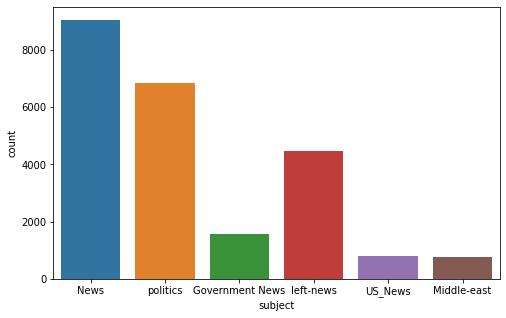

In [24]:
plt.figure(figsize=(8,5))
sns.countplot("subject", data=fake)
plt.show()

In [25]:
#Word Cloud
text = ''
for news in fake.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

KeyboardInterrupt: 

In [26]:
real = pd.read_csv("C:/Users/asus/Desktop/fake news/Fake-News-Detection-System/dataset/True.csv")
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [27]:
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        record[1]
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [28]:
real.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [29]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [30]:
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [31]:
real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [32]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


New column called "Publisher" has been added.


In [33]:
[index for index,text in enumerate(real.text.values) if str(text).strip() == '']

[8970]

In [34]:
real = real.drop(8970, axis=0)

In [35]:
empty_fake_index = [index for index,text in enumerate(fake.text.values) if str(text).strip() == '']
print(f"No of empty rows: {len(empty_fake_index)}")
fake.iloc[empty_fake_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [36]:
print(f"Total Records:\t{real.shape[0]}")

for key,count in real.subject.value_counts().iteritems():
  print(f"{key}:\t{count}")

Total Records:	21416
politicsNews:	11271
worldnews:	10145


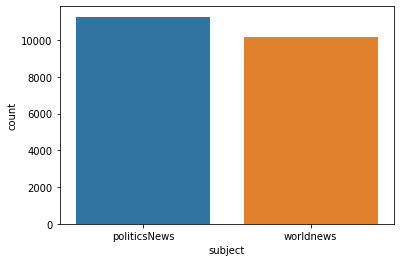

In [37]:
sns.countplot(x="subject", data=real)
plt.show()

In [38]:
text = ''
for news in real.text.values:
    text += f" {news}"
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
del text

KeyboardInterrupt: 

# Preprocessing Text

In [39]:
real["class"] = 1
fake["class"] = 0

In [40]:
real["text"] = real["title"] + " " + real["text"]
fake["text"] = fake["title"] + " " + fake["text"]

In [41]:
real = real.drop(["subject", "date","title",  "publisher"], axis=1)
fake = fake.drop(["subject", "date", "title"], axis=1)

In [42]:
data = real.append(fake, ignore_index=True)
del real, fake

Removing StopWords, Punctuations and single-character words

In [43]:
y = data["class"].values
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in data["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del data

In [44]:
import gensim

In [66]:
EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

Exception in thread Exception in thread Exception in thread Thread-28:
Traceback (most recent call last):
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
Thread-26Thread-27:
Traceback (most recent call last):
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
:
Traceback (most recent call last):
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 910, in run
        self.run()
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 910, in run
self.run()
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\asus\AppData\Local\Programs\Python\Python39\lib\site-packages\gensim\mode

In [47]:
# len(w2v_model.wv.vocab)

In [ ]:
w2v_model

### Exploring Vectors

Lets checkout these vectors

In [49]:
w2v_model["corona"]

TypeError: 'Word2Vec' object is not subscriptable

In [50]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8893005847930908),
 ('iranian', 0.7585371136665344),
 ('destabilizing', 0.6379001140594482),
 ('hezbollah', 0.6318674087524414),
 ('iranians', 0.6232737302780151),
 ('nuclear', 0.6162570714950562),
 ('riyadh', 0.6052611470222473),
 ('ballistic', 0.5874605178833008),
 ('saudis', 0.5823320150375366),
 ('jcpoa', 0.5819787383079529)]

In [51]:
w2v_model.wv.most_similar("fbi")

[('comey', 0.728821873664856),
 ('investigators', 0.6519351005554199),
 ('cia', 0.6406076550483704),
 ('investigation', 0.6078953146934509),
 ('mueller', 0.5994268655776978),
 ('doj', 0.5842684507369995),
 ('investigations', 0.5625181794166565),
 ('probe', 0.5589779019355774),
 ('tapes', 0.544352114200592),
 ('nunes', 0.540820837020874)]

In [52]:
w2v_model.wv.most_similar("facebook")

[('reddit', 0.6603783369064331),
 ('instagram', 0.6552175283432007),
 ('gofundme', 0.6307972073554993),
 ('online', 0.6273642182350159),
 ('fb', 0.6129888892173767),
 ('google', 0.5904009342193604),
 ('869655312239697920twitter', 0.5764542818069458),
 ('hashtag', 0.5723732709884644),
 ('ratherour', 0.5692132711410522),
 ('posting', 0.562406599521637)]

In [53]:
w2v_model.wv.most_similar("computer")

[('computers', 0.8379989266395569),
 ('software', 0.7803844213485718),
 ('laptop', 0.7775094509124756),
 ('malware', 0.7562975883483887),
 ('electronic', 0.7447890043258667),
 ('servers', 0.7403350472450256),
 ('kaspersky', 0.7061630487442017),
 ('encrypted', 0.7004638314247131),
 ('scanning', 0.695411205291748),
 ('devices', 0.6877157092094421)]

In [54]:
w2v_model.wv.most_similar(positive=["trump","obama", "clinton"])


[('elect', 0.5438284277915955),
 ('cruz', 0.5336113572120667),
 ('incoming', 0.5293706059455872),
 ('bush', 0.5173971652984619),
 ('hillary', 0.4973849654197693),
 ('crooked', 0.48875463008880615),
 ('americas_dad', 0.45512086153030396),
 ('dithering', 0.4493248462677002),
 ('course', 0.44553789496421814),
 ('sanders', 0.4405449330806732)]

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [56]:
X[0][:10]

[389, 395, 10495, 54, 5509, 1286, 4840, 315, 205, 16]

In [57]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


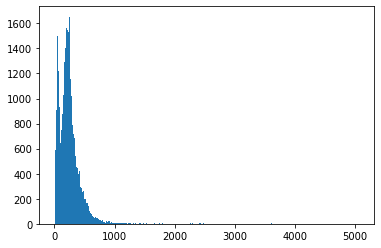

In [58]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [59]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

43982

In [60]:
maxlen = 700 

X = pad_sequences(X, maxlen=maxlen)

In [61]:
len(X[0])

700

In [62]:
vocab_size = len(tokenizer.word_index) + 1

In [63]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [64]:
embedding_vectors = get_weight_matrix(w2v_model, word_index)

TypeError: 'Word2Vec' object is not subscriptable

In [65]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

NameError: name 'embedding_vectors' is not defined

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 700, 100)          12224900  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 12,342,277
Trainable params: 117,377
Non-trainable params: 12,224,900
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Train on 23570 samples, validate on 10102 samples
Epoch 1/6
23570/23570 [==============================] - 36s 2ms/sample - loss: 0.1336 - acc: 0.9517 - val_loss: 0.1205 - val_acc: 0.9591
Epoch 2/6
23570/23570 [==============================] - 31s 1ms/sample - loss: 0.0664 - acc: 0.9770 - val_loss: 0.0407 - val_acc: 0.9869
Epoch 3/6
23570/23570 [==============================] - 31s 1ms/sample - loss: 0.0385 - acc: 0.9877 - val_loss: 0.0348 - val_acc: 0.9897
Epoch 4/6
23570/23570 [==============================] - 31s 1ms/sample - loss: 0.0434 - acc: 0.9847 - val_loss: 0.0321 - val_acc: 0.9891
Epoch 5/6
23570/23570 [==============================] - 31s 1ms/sample - loss: 0.0232 - acc: 0.9918 - val_loss: 0.0242 - val_acc: 0.9918
Epoch 6/6
23570/23570 [==============================] - 31s 1ms/sample - loss: 0.0181 - acc: 0.9939 - val_loss: 0.0186 - val_acc: 0.9936


In [ ]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

0.9923385300668152

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5899
           1       0.99      0.99      0.99      5326

    accuracy                           0.99     11225
   macro avg       0.99      0.99      0.99     11225
weighted avg       0.99      0.99      0.99     11225

